In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

sns.set(style="whitegrid", palette="muted")

tips = sns.load_dataset("tips")
numeric_cols = tips.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = tips.select_dtypes(include=["object", "category"]).columns.tolist()

np.random.seed(42)

tips_with_missing = tips.copy()

missing_fraction = 0.01  # % пропусков

for col in numeric_cols + categorical_cols:
    mask = np.random.rand(len(tips_with_missing)) < missing_fraction
    tips_with_missing.loc[mask, col] = np.nan

tips = tips_with_missing.copy()

In [2]:
print("=== Первичный анализ ===")
print(f"Размерность данных: {tips.shape}")
print("\nПервые 5 строк данных:")
display(tips.head())
print("\nИнформация о типах данных:")
tips.info()

display(tips.describe())

print(f"\nЧисловые признаки: {numeric_cols}")
print(f"Категориальные признаки: {categorical_cols}")

=== Первичный анализ ===
Размерность данных: (244, 7)

Первые 5 строк данных:


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2.0
1,10.34,1.66,Male,No,Sun,Dinner,3.0
2,21.01,3.50,Male,No,Sun,Dinner,3.0
3,23.68,3.31,Male,No,Sun,Dinner,2.0
4,24.59,3.61,Female,No,Sun,Dinner,4.0



Информация о типах данных:
<class 'pandas.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  240 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         243 non-null    category
 3   smoker      243 non-null    category
 4   day         242 non-null    category
 5   time        242 non-null    category
 6   size        244 non-null    float64 
dtypes: category(4), float64(3)
memory usage: 7.4 KB


,total_bill,tip,size
count,240.000000,244.000000,244.000000
mean,19.786625,2.998279,2.569672
std,8.941151,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.065000,3.562500,3.000000
max,50.810000,10.000000,6.000000



Числовые признаки: ['total_bill', 'tip', 'size']
Категориальные признаки: ['sex', 'smoker', 'day', 'time']


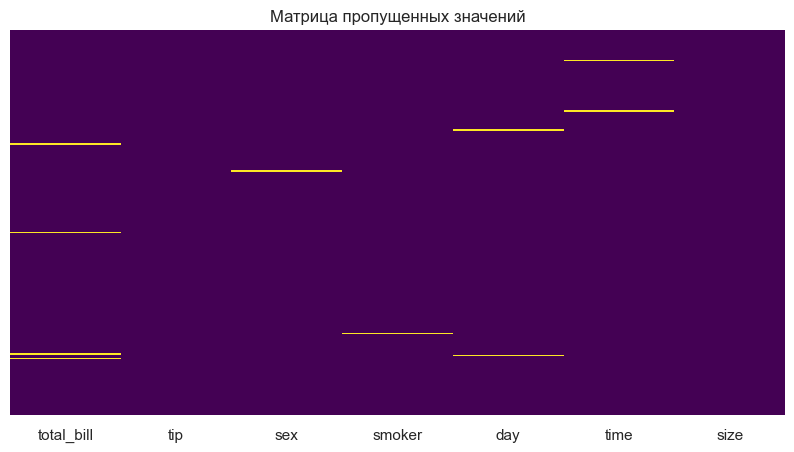

In [3]:
plt.figure(figsize=(10, 5))
sns.heatmap(tips_with_missing.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Матрица пропущенных значений")
plt.show()

In [4]:
print("\n=== Пропущенные значения ===")
missing_counts = tips.isnull().sum()
missing_percent = tips.isnull().mean() * 100
print("\nПропуски по столбцам:")
missings = pd.DataFrame(
    data=[missing_counts, missing_percent],
    index=["Количество пропусков", "Процент пропусков"],
).T
display(missings)

tips_processed = tips.copy()

for col in numeric_cols:
    if tips_processed[col].isnull().any():
        median_value = tips_processed[col].median()
        tips_processed[col] = tips_processed[col].fillna(median_value)
        print(f"Заполнены пропуски в {col} медианой ({median_value})")

for col in categorical_cols:
    if tips_processed[col].isnull().any():
        mode_value = tips_processed[col].mode()[0]
        tips_processed[col] = tips_processed[col].fillna(mode_value)
        print(f"Заполнены пропуски в {col} модой ({mode_value})")


=== Пропущенные значения ===

Пропуски по столбцам:


,Количество пропусков,Процент пропусков
total_bill,4.0,1.639344
tip,0.0,0.000000
sex,1.0,0.409836
smoker,1.0,0.409836
day,2.0,0.819672
time,2.0,0.819672
size,0.0,0.000000


Заполнены пропуски в total_bill медианой (17.795)
Заполнены пропуски в sex модой (Male)
Заполнены пропуски в smoker модой (No)
Заполнены пропуски в day модой (Sat)
Заполнены пропуски в time модой (Dinner)


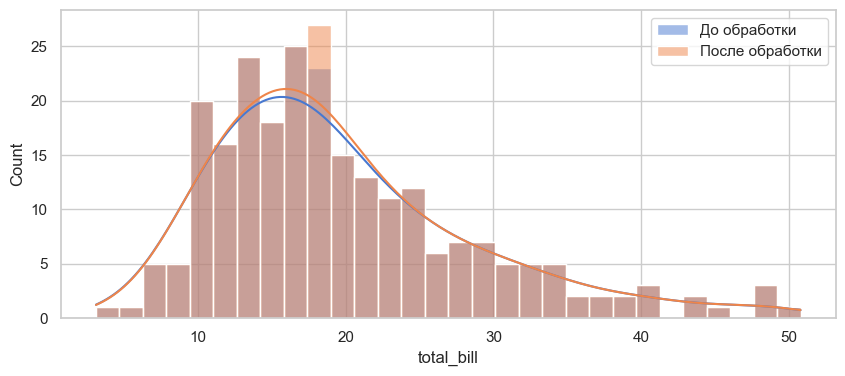

In [5]:
plt.figure(figsize=(10, 4))

sns.histplot(tips["total_bill"], bins=30, kde=True, label="До обработки", alpha=0.5)
sns.histplot(
    tips_processed["total_bill"], bins=30, kde=True, label="После обработки", alpha=0.5
)

plt.legend()
plt.show()

In [6]:
for col in categorical_cols:
    tips_processed[col] = tips_processed[col].astype("category")
    print(f"Столбец '{col}' преобразован в category")

Столбец 'sex' преобразован в category
Столбец 'smoker' преобразован в category
Столбец 'day' преобразован в category
Столбец 'time' преобразован в category


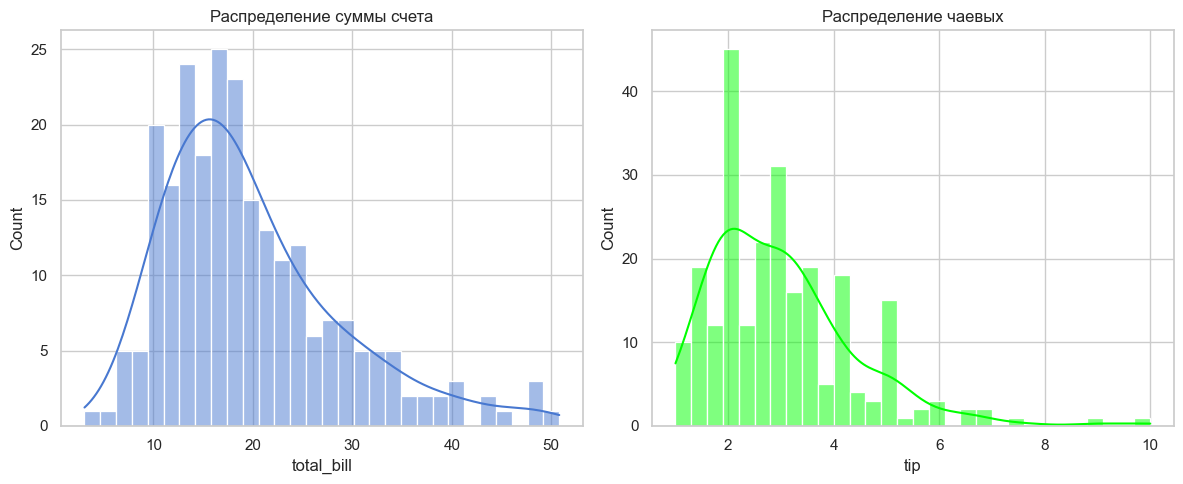

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(tips["total_bill"], bins=30, kde=True)
plt.title("Распределение суммы счета")

plt.subplot(1, 2, 2)
sns.histplot(tips["tip"], bins=30, kde=True, color="lime")
plt.title("Распределение чаевых")

plt.tight_layout()
plt.show()

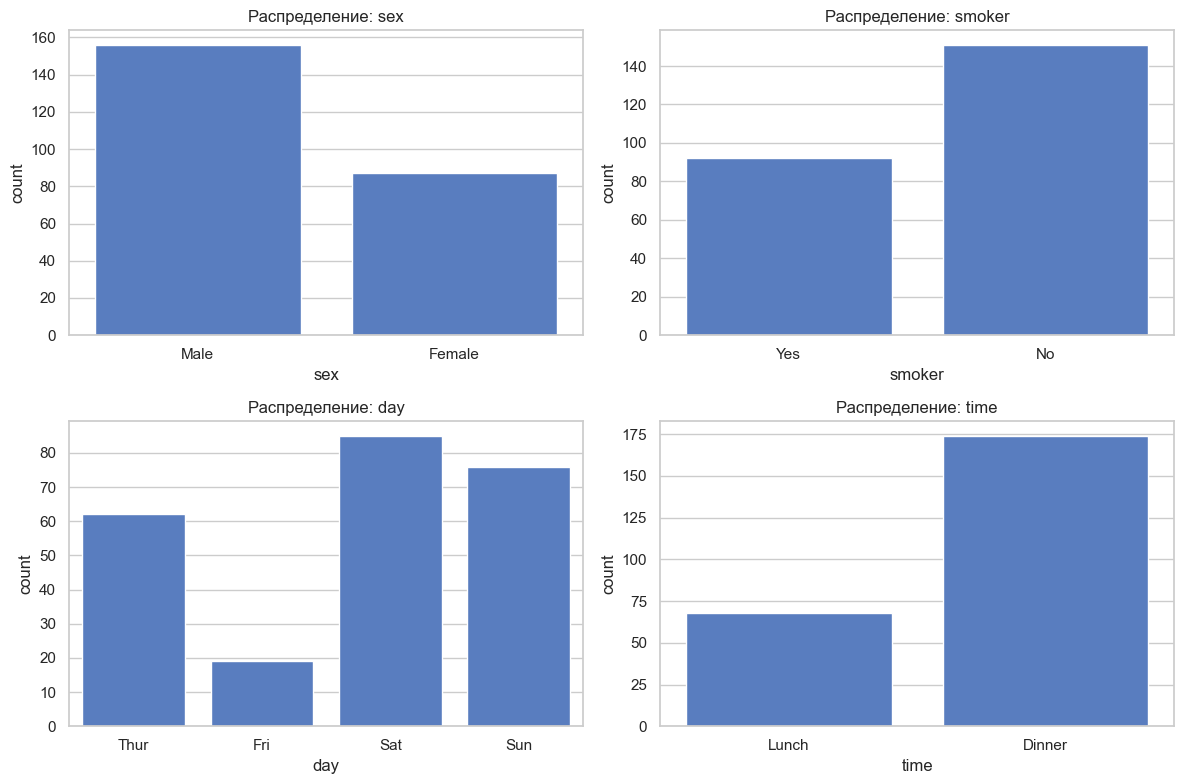

In [8]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=tips, x=col)
    plt.title(f"Распределение: {col}")

plt.tight_layout()
plt.show()

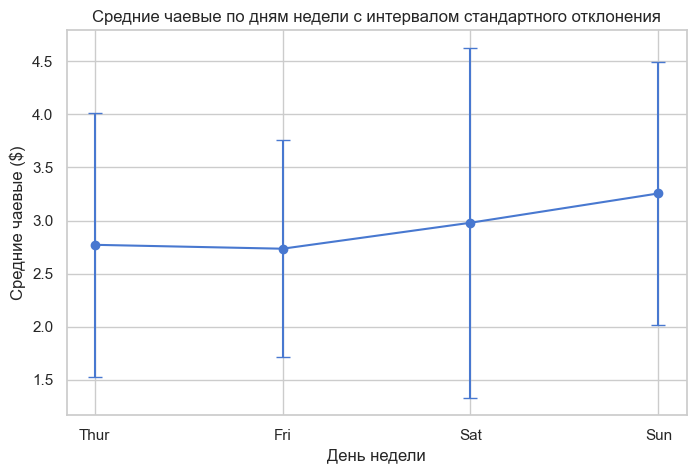

In [9]:
stats_by_day = tips.groupby("day")["tip"].agg(["mean", "std"])

plt.figure(figsize=(8, 5))
plt.errorbar(
    stats_by_day.index,
    stats_by_day["mean"],
    yerr=stats_by_day["std"],
    fmt="o-",
    capsize=5,
)

plt.xlabel("День недели")
plt.ylabel("Средние чаевые ($)")
plt.title("Средние чаевые по дням недели с интервалом стандартного отклонения")
plt.grid(True)
plt.show()

In [10]:
tips_processed = tips_processed.copy()

tips_processed["tip_percentage"] = np.where(
    tips_processed["total_bill"] > 0,
    tips_processed["tip"] / tips_processed["total_bill"] * 100,
    np.nan,
)

tips_processed["size_category"] = pd.cut(
    tips_processed["size"],
    bins=[0, 2, 4, np.inf],
    labels=["small", "medium", "large"],
    include_lowest=True,
)

tips_processed["high_tip"] = (tips_processed["tip_percentage"] > 20).astype(int)

In [11]:
tips_processed.to_csv("processed_tips.csv", index=False)
print("\nОбработанные данные сохранены в processed_tips.csv")

with open("processing_report.txt", "w", encoding="utf-8") as report:
    report.write("=== Отчет по обработке набора данных 'tips' ===\n\n")
    report.write("1. Первичный анализ:\n")
    report.write(f" - Размерность исходных данных: {tips.shape}\n")
    report.write(f" - Числовые признаки: {numeric_cols}\n")
    report.write(f" - Категориальные признаки: {categorical_cols}\n\n")

    report.write("2. Пропущенные значения:\n")
    for col in tips.columns:
        report.write(
            f" - {col}: {missing_counts[col]} пропусков ({missing_percent[col]:.2f}%)\n"
        )
    report.write("Пропущенные значения обработаны.\n\n")

    report.write("3. Преобразование типов данных:\n")
    for col in categorical_cols:
        report.write(f" - {col} преобразован в category\n")
    report.write("\n")

    report.write("4. Созданные новые признаки:\n")
    report.write(
        " - tip_percentage: процент чаевых от суммы счета (важно для анализа щедрости клиентов)\n"
    )
    report.write(
        " - size_category: категория размера группы (маленькая, средняя, большая)\n"
    )
    report.write(" - high_tip: бинарный признак высоких чаевых (>20%)\n\n")

    report.write("5. Статистика по обработанным данным:\n")
    report.write(f" - Количество строк: {tips_processed.shape[0]}\n")
    report.write(f" - Количество столбцов после обработки: {tips_processed.shape[1]}\n")

    report.write("\n6. Рекомендации по использованию обработанных данных:\n")
    report.write(
        " - Использовать признаки tip_percentage и high_tip для моделей прогнозирования поведения клиентов\n"
    )
    report.write(
        " - size_category полезен для сегментации клиентов по размеру группы\n"
    )
    report.write(
        " - Обработанные данные готовы для использования в задачах ИИ и машинного обучения\n"
    )


Обработанные данные сохранены в processed_tips.csv


In [12]:
tips = tips_processed

high_tip = tips[tips["tip_percentage"] > 20]

weekend = tips[tips["day"].isin(["Sat", "Sun"])]

large_groups = tips[tips["size"] >= 4]

high_tip_large_weekend = tips[
    (tips["tip_percentage"] > 20)
    & (tips["size"] >= 4)
    & (tips["day"].isin(["Sat", "Sun"]))
]

print(f"Всего наблюдений с high_tip: {len(high_tip)}")
print(f"Всего наблюдений в выходные: {len(weekend)}")
print(f"Всего наблюдений для крупных групп: {len(large_groups)}")
print(f"Объединенное подмножество: {len(high_tip_large_weekend)}")

print("Крупные компании в выходные с чаевыми > 20%")
display(high_tip_large_weekend)

Всего наблюдений с high_tip: 39
Всего наблюдений в выходные: 163
Всего наблюдений для крупных групп: 46
Объединенное подмножество: 3
Крупные компании в выходные с чаевыми > 20%


,total_bill,tip,sex,smoker,day,time,size,tip_percentage,size_category,high_tip
63,18.29,3.76,Male,Yes,Sat,Dinner,4.0,20.557682,medium,1
183,23.17,6.50,Male,Yes,Sun,Dinner,4.0,28.053517,medium,1
185,20.69,5.00,Male,No,Sun,Dinner,5.0,24.166264,large,1


In [13]:
grouped = tips.groupby(["day", "time"])

stats = grouped[["total_bill", "tip_percentage"]].agg(["mean", "median", "std"])
print("Расчет статистик: среднее, медиана, стандартное отклонение")
display(stats)

Расчет статистик: среднее, медиана, стандартное отклонение


total_bill                   tip_percentage                     
                  mean  median       std           mean     median       std
day  time                                                                   
Thur Lunch   17.791639  16.400  7.906322      16.002273  15.349194  3.924490
     Dinner  18.780000  18.780       NaN      15.974441  15.974441       NaN
Fri  Lunch   12.845714  13.420  2.842228      18.876489  18.773467  4.588535
     Dinner  19.663333  18.665  9.471753      15.891611  14.474235  4.702412
Sat  Dinner  20.262759  17.920  9.453012      15.418604  15.203022  5.081786
Sun  Dinner  21.410000  19.630  8.832122      16.689729  16.110332  8.473889

In [14]:
grouped_extended = tips.groupby(["day", "time", "sex", "smoker"])
stats_extended = grouped_extended[["total_bill", "tip_percentage"]].agg(
    ["mean", "median", "std"]
)
print("Дополнительная группировка с учетом пола официанта и курящего статуса")
display(stats_extended)

Дополнительная группировка с учетом пола официанта и курящего статуса


total_bill                    tip_percentage  \
                                mean  median        std           mean   
day  time   sex    smoker                                                
Thur Lunch  Male   Yes     18.141111  16.580   6.279971      17.268373   
                   No      18.960476  17.290   8.790424      16.210196   
            Female Yes     19.407857  16.400  10.802649      16.098650   
                   No      16.166458  13.785   6.846177      15.317443   
     Dinner Female No      18.780000  18.780        NaN      15.974441   
Fri  Lunch  Male   Yes     11.386667  12.160   2.510963      17.414400   
            Female Yes     13.260000  13.420   3.093105      20.372918   
                   No      15.980000  15.980        NaN      18.773467   
     Dinner Male   Yes     25.892000  27.280  10.383290      12.708199   
                   No      17.475000  17.475   7.092281      13.800498   
            Female Yes     12.200000  13.365   4.810121      21.317907   
                   No      22.750000  22.750        NaN      14.285714   
Sat  Dinner Male   Yes     21.597963  18.290  10.005119      14.019402   
                   No      19.929063  17.870   9.779061      16.213217   
            Female Yes     19.662333  17.795  10.338756      16.778683   
                   No      19.003846  17.070   6.730219      14.799347   
Sun  Dinner Male   Yes     26.141333  23.330  10.693824      17.396381   
                   No      20.403256  19.490   8.140559      15.829067   
            Female Yes     16.540000  17.830   4.854764      23.707473   
                   No      20.824286  17.150   8.396159      16.570992   

                                                 
                              median        std  
day  time   sex    smoker                        
Thur Lunch  Male   Yes     15.432099   3.984121  
                   No      15.673800   4.878612  
            Female Yes     15.384615   2.939552  
                   No      14.307685   3.247694  
     Dinner Female No      15.974441        NaN  
Fri  Lunch  Male   Yes     18.092105   5.334460  
            Female Yes     19.821606   5.304402  
                   No      18.773467        NaN  
     Dinner Male   Yes     12.468828   1.785405  
                   No      13.800498   2.491808  
            Female Yes     20.766142   3.851666  
                   No      14.285714        NaN  
Sat  Dinner Male   Yes     14.482259   5.051893  
                   No      15.435249   4.063484  
            Female Yes     17.476489   7.436392  
                   No      14.935506   3.713532  
Sun  Dinner Male   Yes     10.620491  16.293658  
                   No      16.277808   4.149784  
            Female Yes     18.208407  12.024713  
                   No      15.862327   4.600652

In [15]:
tip_std = (
    tips.groupby(["day", "time"])["tip_percentage"].std().sort_values(ascending=False)
)
print("Стандартное отклонение процента чаевых по дням и времени")
display(tip_std.to_frame())

Стандартное отклонение процента чаевых по дням и времени


tip_percentage
day  time                  
Sun  Dinner        8.473889
Sat  Dinner        5.081786
Fri  Dinner        4.702412
     Lunch         4.588535
Thur Lunch         3.924490
     Dinner             NaN

In [16]:
pivot = pd.pivot_table(
    tips,
    values="tip_percentage",
    index="day",
    columns="time",
    aggfunc=["mean", "count"],
)
print("Средний процент чаевых по дням и времени")
display(pivot)

Средний процент чаевых по дням и времени


mean            count       
time      Lunch     Dinner Lunch Dinner
day                                    
Thur  16.002273  15.974441  61.0    1.0
Fri   18.876489  15.891611   7.0   12.0
Sat         NaN  15.418604   NaN   87.0
Sun         NaN  16.689729   NaN   76.0

In [17]:
pivot_sex = pd.pivot_table(
    tips,
    values="tip_percentage",
    index=["day", "sex"],
    columns="time",
    aggfunc=["mean", "count"],
)
print("Сводная таблица с третьим измерением - пол официанта")
display(pivot_sex)

Сводная таблица с третьим измерением - пол официанта


mean            count       
time             Lunch     Dinner Lunch Dinner
day  sex                                      
Thur Male    16.527649        NaN  30.0    NaN
     Female  15.493845  15.974441  31.0    1.0
Fri  Male    17.414400  13.020284   3.0    7.0
     Female  19.973055  19.911468   4.0    5.0
Sat  Male          NaN  15.209268   NaN   59.0
     Female        NaN  15.859706   NaN   28.0
Sun  Male          NaN  16.234407   NaN   58.0
     Female        NaN  18.156877   NaN   18.0

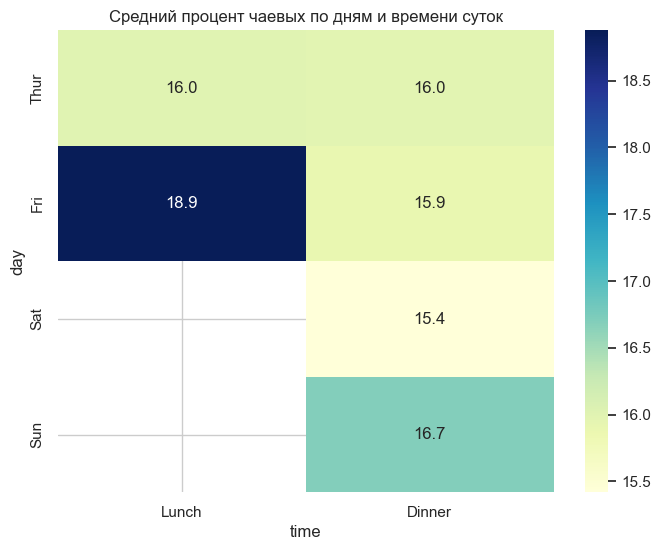

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    pd.pivot_table(
        tips, values="tip_percentage", index="day", columns="time", aggfunc="mean"
    ),
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
)
plt.title("Средний процент чаевых по дням и времени суток")
plt.show()

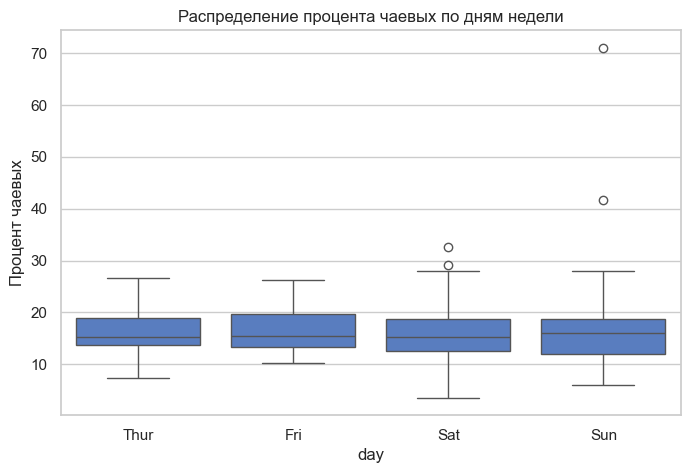

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="day", y="tip_percentage", data=tips)
plt.title("Распределение процента чаевых по дням недели")
plt.ylabel("Процент чаевых")
plt.show()

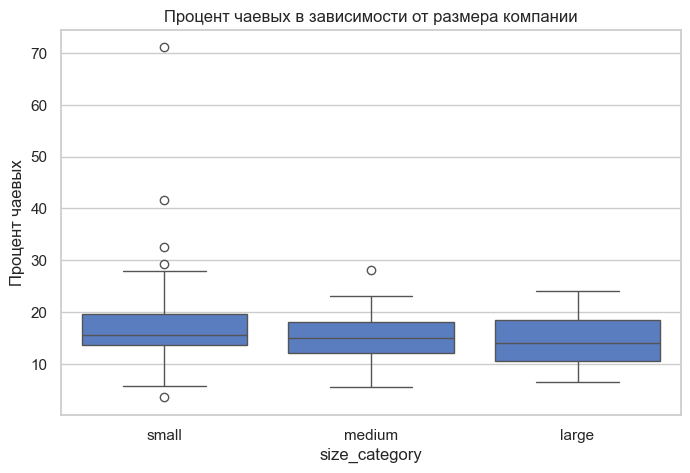

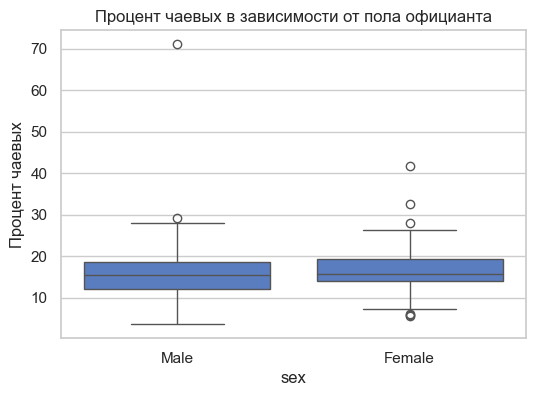

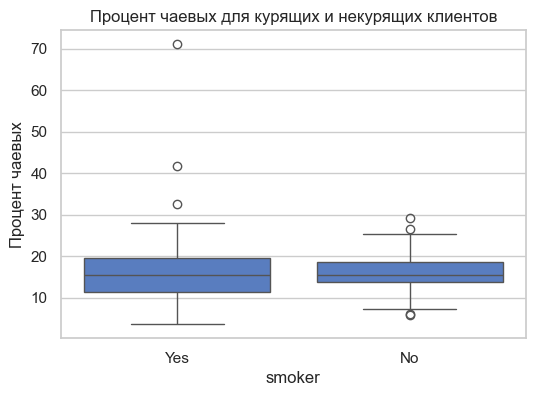

In [20]:
# Влияние размера компании
plt.figure(figsize=(8, 5))
sns.boxplot(x="size_category", y="tip_percentage", data=tips)
plt.title("Процент чаевых в зависимости от размера компании")
plt.ylabel("Процент чаевых")
plt.show()

# Влияние пола официанта
plt.figure(figsize=(6, 4))
sns.boxplot(x="sex", y="tip_percentage", data=tips)
plt.title("Процент чаевых в зависимости от пола официанта")
plt.ylabel("Процент чаевых")
plt.show()

# Влияние курящего статуса
plt.figure(figsize=(6, 4))
sns.boxplot(x="smoker", y="tip_percentage", data=tips)
plt.title("Процент чаевых для курящих и некурящих клиентов")
plt.ylabel("Процент чаевых")
plt.show()

In [21]:
with PdfPages("tips_analysis_report.pdf") as pdf:
    plt.figure(figsize=(10, 6))
    plt.axis("off")
    pivot_table_str = pivot.to_string()
    plt.text(
        0,
        1,
        "Сводная таблица: Средний процент чаевых и количество наблюдений по дням и времени суток",
        fontsize=12,
        va="top",
    )
    plt.text(0, 0.95, pivot_table_str, fontsize=10, va="top", family="monospace")
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        pd.pivot_table(
            tips, values="tip_percentage", index="day", columns="time", aggfunc="mean"
        ),
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
    )
    plt.title("Heatmap: средний процент чаевых по дням и времени суток")
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(8, 5))
    sns.boxplot(x="day", y="tip_percentage", data=tips)
    plt.title("Распределение процента чаевых по дням недели")
    plt.ylabel("Процент чаевых")
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(8, 5))
    sns.boxplot(x="size_category", y="tip_percentage", data=tips)
    plt.title("Процент чаевых в зависимости от размера компании")
    plt.ylabel("Процент чаевых")
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x="sex", y="tip_percentage", data=tips)
    plt.title("Процент чаевых в зависимости от пола официанта")
    plt.ylabel("Процент чаевых")
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x="smoker", y="tip_percentage", data=tips)
    plt.title("Процент чаевых для курящих и некурящих клиентов")
    plt.ylabel("Процент чаевых")
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.axis("off")
    conclusions = [
        "Выводы по поведению клиентов:",
        "- Наибольшие чаевые оставляются в выходные и в вечернее время",
        "- Крупные компании чаще оставляют более высокие чаевые",
        "- Пол официанта оказывает небольшое влияние на размер чаевых",
        "- Курящие клиенты демонстрируют большую вариацию чаевых",
        "",
        "Практические рекомендации для ресторана:",
        "- Продвигать специальные предложения в выходные дни",
        "- Особое внимание обслуживанию крупных групп",
        "- Оптимизировать распределение персонала по времени и дням",
        "- Использовать данные о чаевых при разработке системы рекомендаций",
    ]

    for i, line in enumerate(conclusions):
        plt.text(0, 1 - i * 0.08, line, fontsize=12, va="top")

    pdf.savefig()
    plt.close()